In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kidney-stone-prediction-based-on-urine-analysis/kindey stone urine analysis.csv
/kaggle/input/playground-series-s3e12/sample_submission.csv
/kaggle/input/playground-series-s3e12/train.csv
/kaggle/input/playground-series-s3e12/test.csv


We will use this dataset to predict the presence of kidney stones based on urine analysis.

The 79 urine specimens, were analyzed in an effort to determine if certain physical characteristics of the urine might be related to the formation of calcium oxalate crystals.

The six physical characteristics of the urine mentioned in this dataset are:

(1) specific gravity, the density of the urine relative to water;
(2) pH, the negative logarithm of the hydrogen ion;
(3) osmolarity (mOsm), a unit used in biology and medicine but not in physical chemistry. Osmolarity is proportional to the concentration of molecules in solution;
(4) conductivity (mMho milliMho). One Mho is one reciprocal Ohm. Conductivity is proportional to the concentration of charged ions in solution;
(5) urea concentration in millimoles per litre;
(6) calcium concentration (CALC) in millimolesllitre.

The data is obtained from 'Physical Characteristics of Urines With and Without Crystals',a chapter from Springer Series in Statistics.

https://link.springer.com/chapter/10.1007/978-1-4612-5098-2_45

In [3]:
df=pd.read_csv(r"/kaggle/input/kidney-stone-prediction-based-on-urine-analysis/kindey stone urine analysis.csv")

In [4]:
df.head()

,gravity,ph,osmo,cond,urea,calc,target
0,1.021,4.91,725,14.0,443,2.45,0
1,1.017,5.74,577,20.0,296,4.49,0
2,1.008,7.20,321,14.9,101,2.36,0
3,1.011,5.51,408,12.6,224,2.15,0
4,1.005,6.52,187,7.5,91,1.16,0


We see that this is less data so we get some more data from the Playground series based on the same data. 

In [5]:
df_2=pd.read_csv(r"/kaggle/input/playground-series-s3e12/train.csv")

In [6]:
df_2.drop(columns='id',inplace=True)

In [7]:
df_2.head()

,gravity,ph,osmo,cond,urea,calc,target
0,1.013,6.19,443,14.8,124,1.45,0
1,1.025,5.40,703,23.6,394,4.18,0
2,1.009,6.13,371,24.5,159,9.04,0
3,1.021,4.91,442,20.8,398,6.63,1
4,1.021,5.53,874,17.8,385,2.21,1


We combine them both to get one dataframe.

In [8]:
df_f=pd.concat([df,df_2])
df_f.shape

(493, 7)

Let us take a look at the distribution of the data and some statistics.

In [9]:
df_f.describe()

,gravity,ph,osmo,cond,urea,calc,target
count,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000
mean,1.017929,5.967160,645.344828,21.337931,276.693712,4.118540,0.442191
std,0.006761,0.655861,235.320087,7.579484,135.568157,3.221149,0.497151
min,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,0.000000
25%,1.012000,5.530000,450.000000,15.500000,164.000000,1.450000,0.000000
50%,1.018000,5.770000,668.000000,21.900000,272.000000,3.160000,0.000000
75%,1.022000,6.280000,838.000000,27.600000,385.000000,6.630000,1.000000
max,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000,1.000000


In [24]:
df_f['target'].value_counts()

0    275
1    218
Name: target, dtype: int64

These are roughly comparable so we assume that there is zero to no imbalance in the dataset.  

Now, we plot the distribution of the features based on the target feature. 

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_features(df, target_column):
    features = df.columns.tolist()
    features.remove(target_column)

    for feature in features:
        plt.figure(figsize=(12, 6))

        # Plotting bar graph
        plt.subplot(1, 2, 1)
        sns.countplot(data=df, x=feature)
        plt.title(f'{feature} - Bar Graph')

        # Plotting KDE plot
        plt.subplot(1, 2, 2)
        sns.kdeplot(data=df, x=feature, hue=target_column, fill=True)
        plt.title(f'{feature} - KDE Plot')

        plt.tight_layout()
        plt.show()

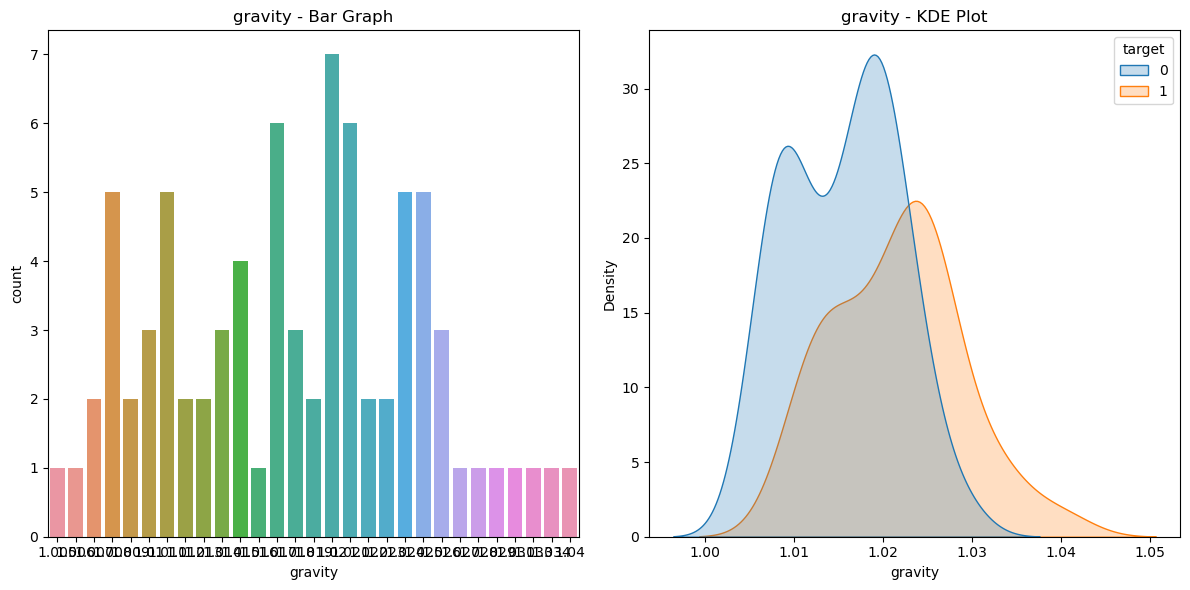

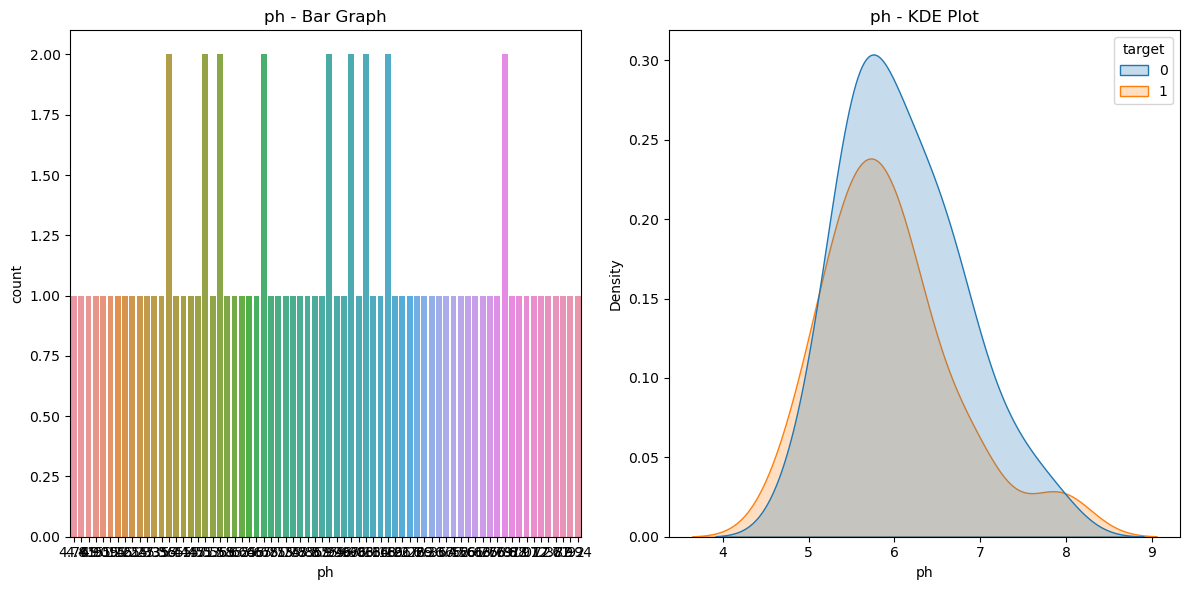

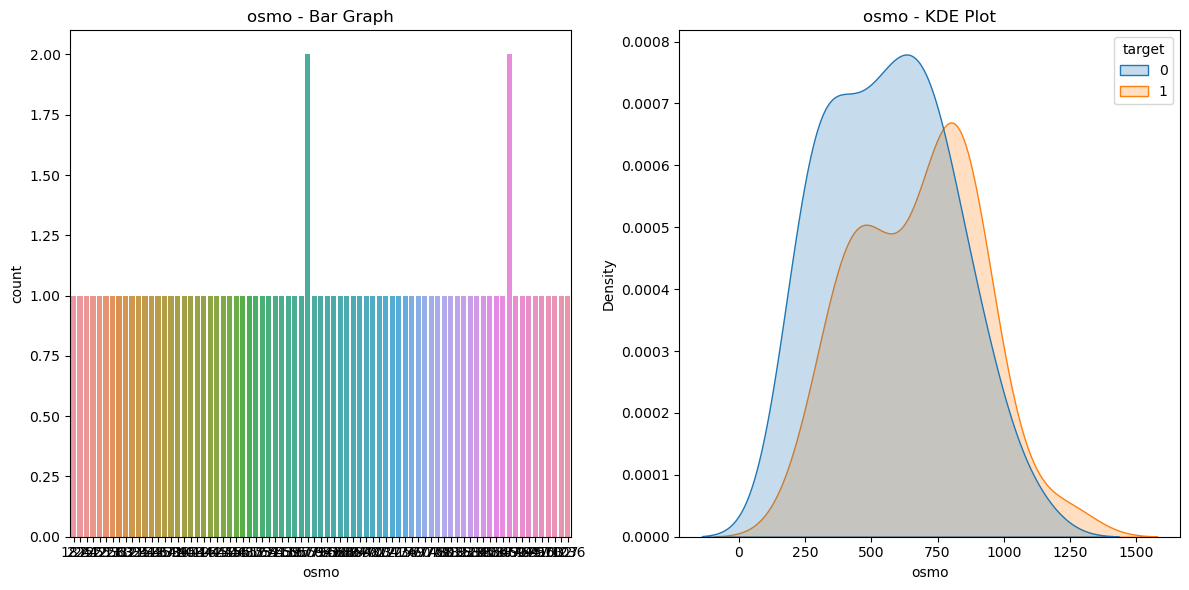

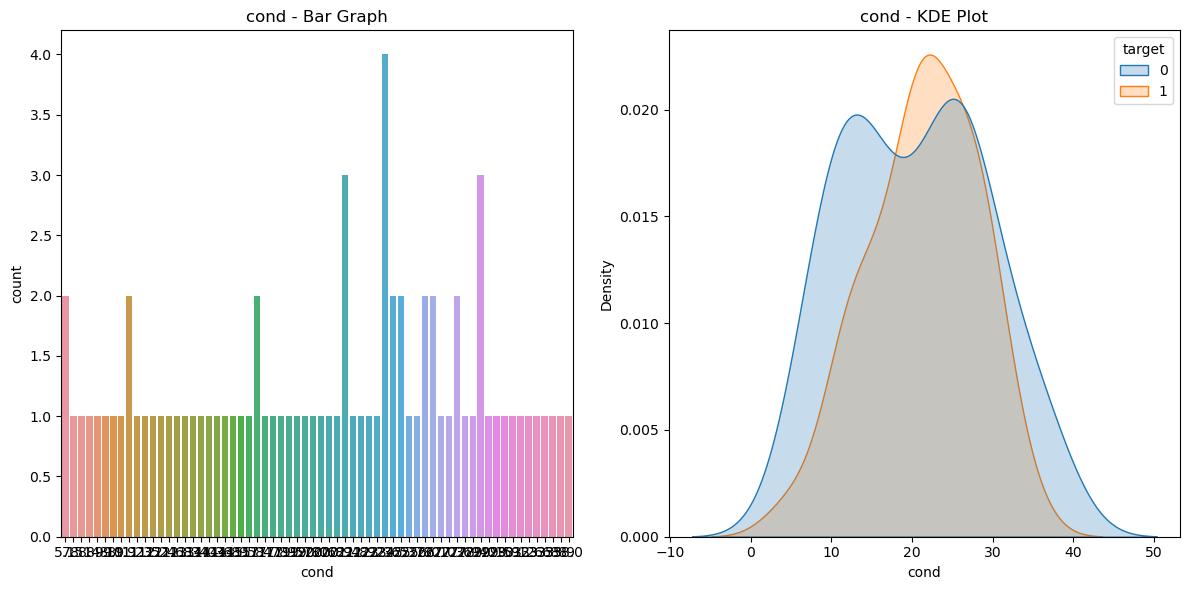

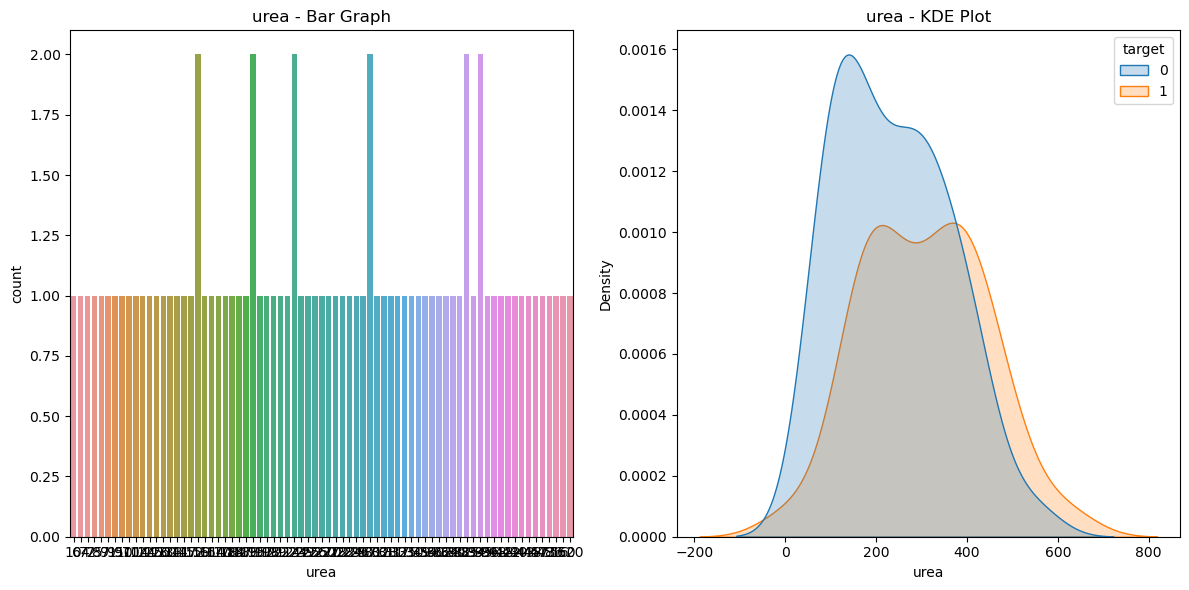

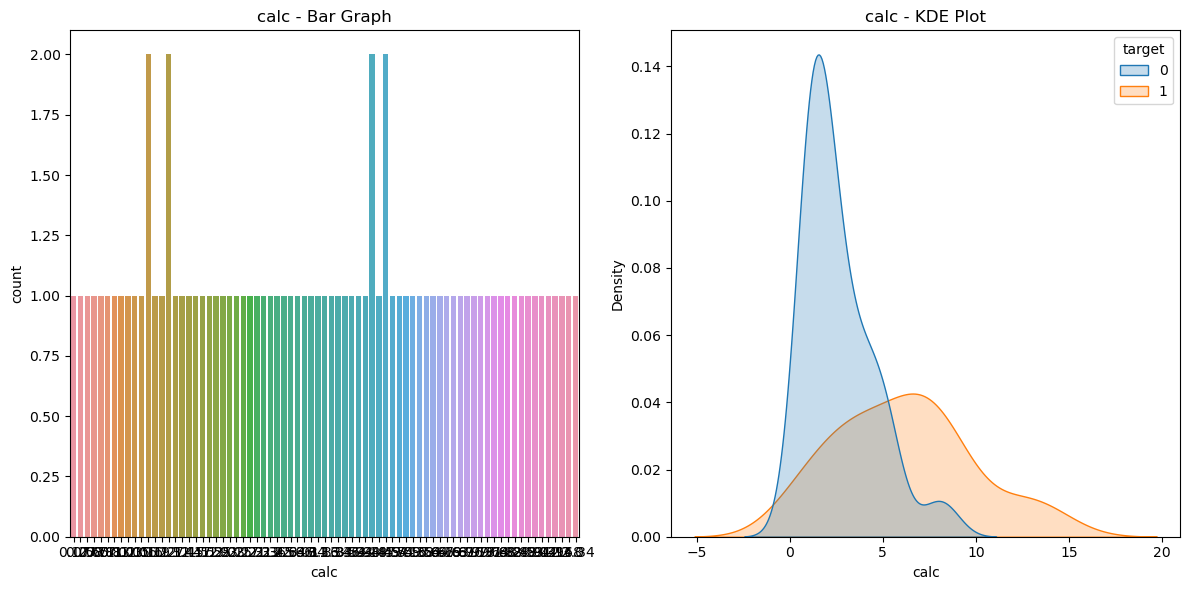

In [11]:
plot_features(df, 'target')

In [12]:
df_f.columns

Index(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target'], dtype='object')

Now, as a part of basic pre-processing we will standardise all columns. We will not drop any column or rows because we don't want to lose any data. 

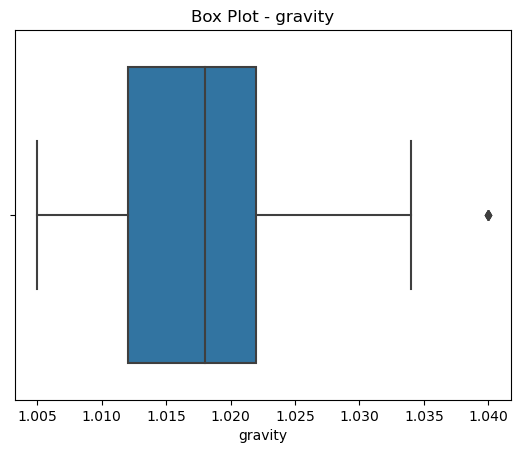

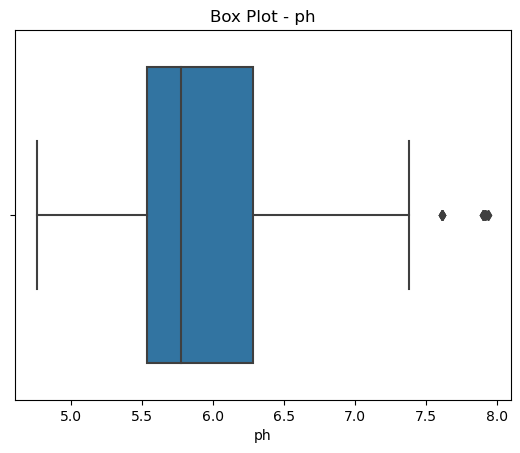

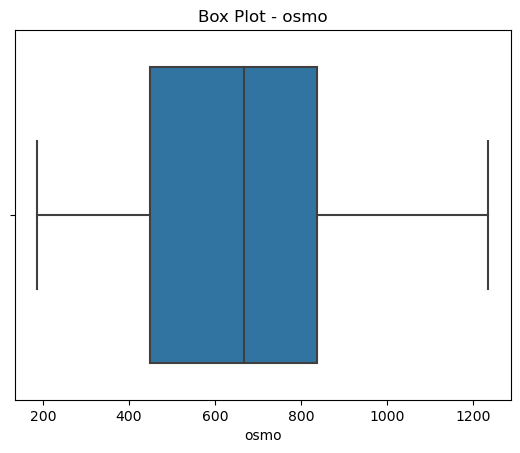

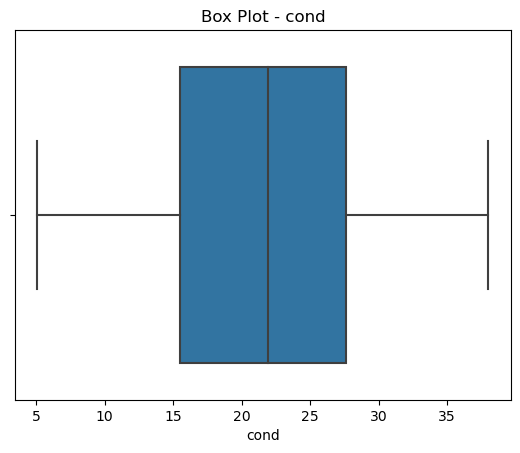

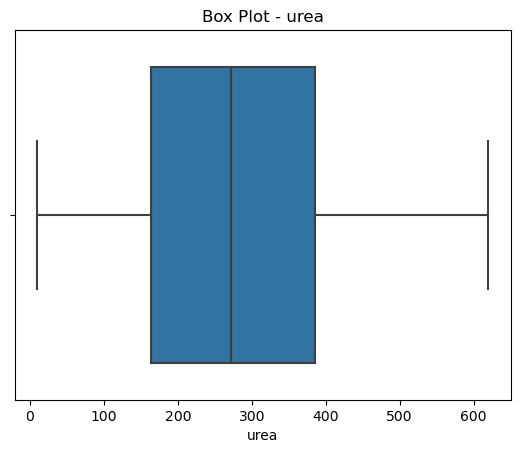

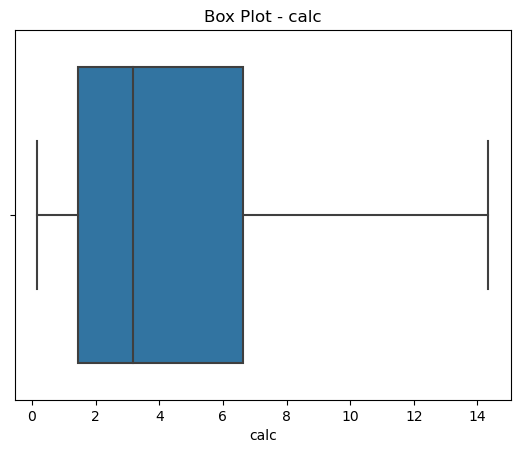

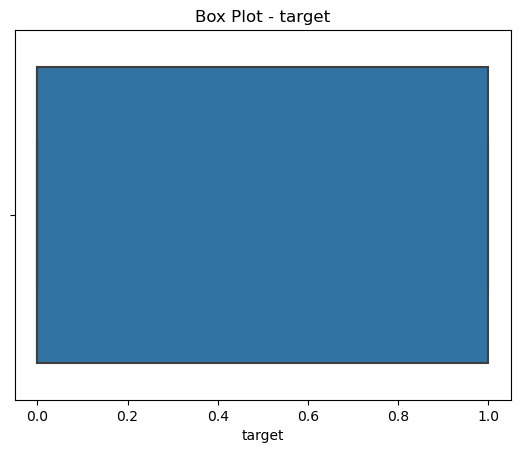

In [25]:
for column in df_f.columns:
    sns.boxplot(x=column, data=df_f)
    plt.title(f'Box Plot - {column}')
    plt.show()

The plot for target is redundant. For the others we have a few outliers so we do not remove them we proceed to modelling. 

In [13]:
from sklearn.preprocessing import StandardScaler
x = df_f.drop('target', axis=1)  
y = df_f['target']               
scaler = StandardScaler()
x_standardized = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

In [14]:
x_standardized.head()

,gravity,ph,osmo,cond,urea,calc
0,0.454656,-1.613503,0.338841,-0.969114,1.227982,-0.518521
1,-0.137538,-0.346706,-0.290728,-0.176699,0.142555,0.115436
2,-1.469976,1.881636,-1.379713,-0.850252,-1.297297,-0.546490
3,-1.025830,-0.697746,-1.009629,-1.154011,-0.389083,-0.611750
4,-1.914122,0.843778,-1.949729,-1.827563,-1.371136,-0.919406


Let's perform a train test split.

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_standardized, y, test_size=0.2, random_state=42)

1. Basic logistic regression model.

In [15]:
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

# Suppress warnings
warnings.filterwarnings("ignore")

# Create a logistic regression model
logreg = LogisticRegression(solver='lbfgs')

# Fit the model on the training data
logreg.fit(x_train, y_train)

# Make predictions on the test data
y_pred = logreg.predict(x_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Compute the test accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Define the parameter grid for grid search
param_grid = {'C': [0.1, 1, 10], 'penalty': ['l2', 'none']}

# Create a GridSearchCV object and fit it on the training data
grid_search = GridSearchCV(logreg, param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Print the best parameters and best score found by grid search
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)



Confusion Matrix:
[[43 10]
 [17 29]]
Test Accuracy: 0.7272727272727273
Best Parameters: {'C': 1, 'penalty': 'l2'}
Best Score: 0.7260305095748133


Let's plot and see the feature importances. 

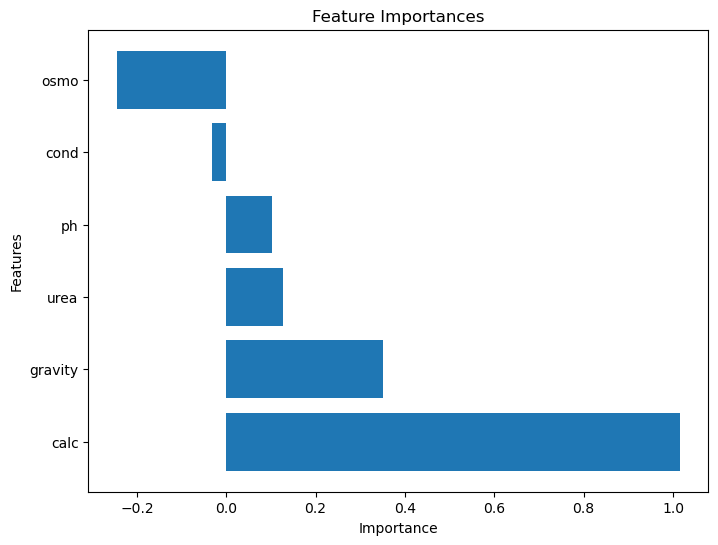

In [16]:
import matplotlib.pyplot as plt

# Get the feature importances from the logistic regression model
importances = logreg.coef_[0]

# Get the names of the features
feature_names = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target']

# Sort the feature importances and feature names in descending order
indices = (-importances).argsort()
sorted_importances = importances[indices]
sorted_feature_names = [feature_names[i] for i in indices]

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_feature_names)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()


Let us fit a few more models.

Let's fit a SVM model now

In [17]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

# Create an SVM model
svm = SVC()

# Fit the model on the training data
svm.fit(x_train, y_train)

# Make predictions on the test data
y_pred = svm.predict(x_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Compute the test accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Create a GridSearchCV object and fit it on the training data
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Print the best parameters and best score found by grid search
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Confusion Matrix:
[[42 11]
 [17 29]]
Test Accuracy: 0.7171717171717171
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.7387211944173969


Some minor improvement now let's fit a decision tree classifier.

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

# Create a Decision Tree Classifier model
dt_classifier = DecisionTreeClassifier()

# Fit the model on the training data
dt_classifier.fit(x_train, y_train)

# Make predictions on the test data
y_pred = dt_classifier.predict(x_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Compute the test accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Define the parameter grid for grid search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10,15, 20],
    'min_samples_split': [2, 5, 10,15,18],
    'min_samples_leaf': [1, 2, 4,5,6,7],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Create a GridSearchCV object and fit it on the training data
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Print the best parameters and best score found by grid search
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Confusion Matrix:
[[39 14]
 [23 23]]
Test Accuracy: 0.6262626262626263
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 5, 'splitter': 'random'}
Best Score: 0.7513469652710159


Let us take a look at the feature importance plot now- 

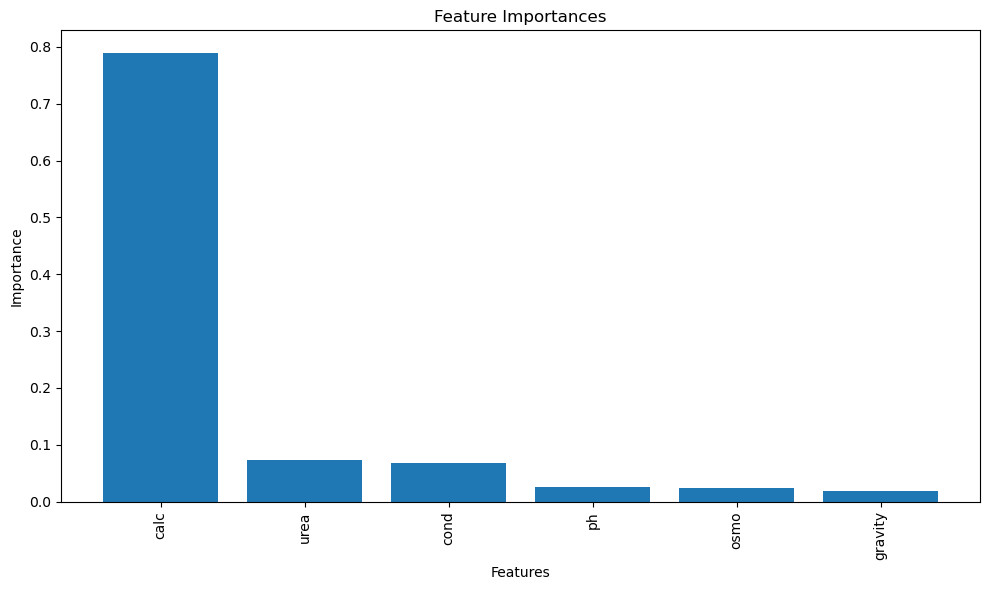

In [19]:
import matplotlib.pyplot as plt

# Get the best estimator/model from the grid search
best_model = grid_search.best_estimator_

# Get feature importances from the best model
feature_importances = best_model.feature_importances_

# Get the names of the features
feature_names = df.columns[:-1]  # Assuming the target column is the last column

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[indices])
plt.xticks(range(len(feature_importances)), feature_names[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


It may overfit so just to reduce the variance let's fit a random forrest classifier on this now-

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

# Create a Random Forest Classifier model
rf_classifier = RandomForestClassifier()

# Fit the model on the training data
rf_classifier.fit(x_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(x_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Compute the test accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100,150,200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create a GridSearchCV object and fit it on the training data
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Print the best parameters and best score found by grid search
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Confusion Matrix:
[[42 11]
 [13 33]]
Test Accuracy: 0.7575757575757576
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.7514118792599807


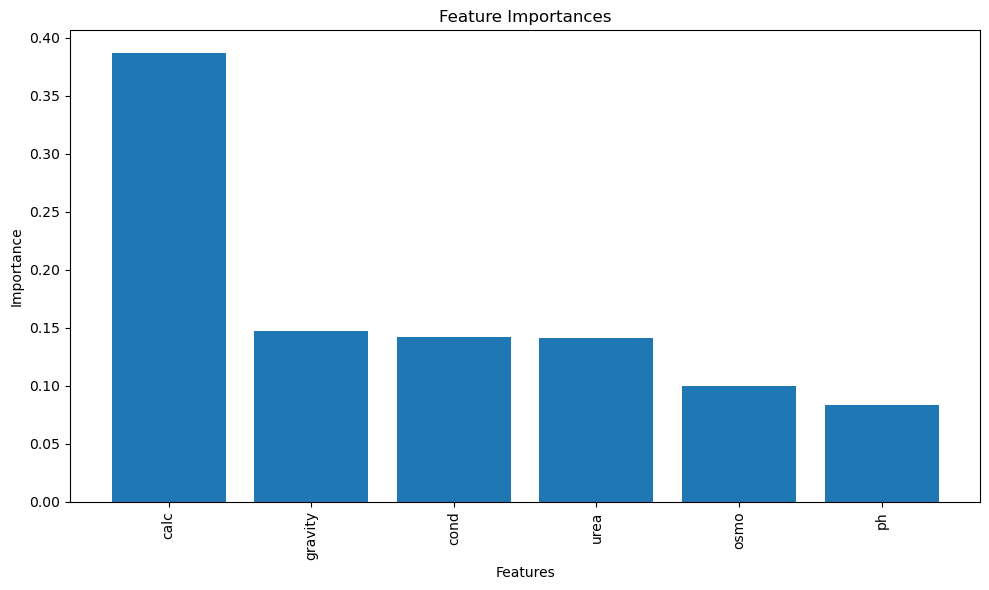

In [27]:
# Get the best model from the GridSearchCV
best_model = grid_search.best_estimator_

# Get feature importances from the best model
importances = best_model.feature_importances_

# Get the column names of the features
feature_names = x.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names based on feature importances
sorted_feature_names = [feature_names[i] for i in indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(x.shape[1]), importances[indices], align="center")
plt.xticks(range(x.shape[1]), sorted_feature_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


Let's try some basic boosting now.

In [28]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

# Create an AdaBoost Classifier model
ada_classifier = AdaBoostClassifier()

# Fit the model on the training data
ada_classifier.fit(x_train, y_train)

# Make predictions on the test data
y_pred = ada_classifier.predict(x_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Compute the test accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.1, 0.5, 1.0, 2.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Create a GridSearchCV object and fit it on the training data
grid_search = GridSearchCV(ada_classifier, param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Print the best parameters and best score found by grid search
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Confusion Matrix:
[[40 13]
 [13 33]]
Test Accuracy: 0.7373737373737373
Best Parameters: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 150}
Best Score: 0.7311587147030185


Let's move on to the LightGBM

In [29]:
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

# Create a LightGBM Classifier model
lgb_classifier = lgb.LGBMClassifier()

# Fit the model on the training data
lgb_classifier.fit(x_train, y_train)

# Make predictions on the test data
y_pred = lgb_classifier.predict(x_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Compute the test accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Define the parameter grid for grid search
param_grid = {
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_child_samples': [10, 20, 30]
}

# Create a GridSearchCV object and fit it on the training data
grid_search = GridSearchCV(lgb_classifier, param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Print the best parameters and best score found by grid search
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Confusion Matrix:
[[42 11]
 [11 35]]
Test Accuracy: 0.7777777777777778
Best Parameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 20}
Best Score: 0.7463161311262576


Finally, let's go to the XGBoost classifier.

In [18]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score
import optuna

# Define the objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 0.0, 2.0),
        'alpha': trial.suggest_float('alpha', 0.0, 2.0),
        'eval_metric': 'logloss',
        'random_state': 42
    }

    # Create an XGBoost Classifier model
    xgb_classifier = xgb.XGBClassifier(**params)

    # Fit the model on the training data
    xgb_classifier.fit(x_train, y_train)

    # Make predictions on the test data
    y_pred = xgb_classifier.predict(x_test)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Compute the test accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", accuracy)

    # Return the negative log-loss as the objective value for optimization
    return accuracy

# Create a study object for Optuna optimization
study = optuna.create_study(direction='maximize')

# Run the optimization
study.optimize(objective, n_trials=100)

# Print the best parameters and best score found by Optuna
print("Best Parameters:", study.best_params)
print("Best Score:", study.best_value)


[I 2023-06-16 16:54:35,968] A new study created in memory with name: no-name-56b189f7-6b9e-46b8-8a4e-419aef810c5d
[I 2023-06-16 16:54:36,285] Trial 0 finished with value: 0.7474747474747475 and parameters: {'n_estimators': 301, 'max_depth': 14, 'learning_rate': 0.056263177795658065, 'subsample': 0.9210297620317394, 'colsample_bytree': 0.6818881361875284, 'lambda': 1.5898615921700636, 'alpha': 0.7011579895346254}. Best is trial 0 with value: 0.7474747474747475.


Confusion Matrix:
[[41 12]
 [13 33]]
Test Accuracy: 0.7474747474747475


[I 2023-06-16 16:54:37,025] Trial 1 finished with value: 0.7575757575757576 and parameters: {'n_estimators': 746, 'max_depth': 17, 'learning_rate': 0.005145877252388997, 'subsample': 0.5869066894705532, 'colsample_bytree': 0.7084570327482624, 'lambda': 0.05019648936426613, 'alpha': 0.29896501471350256}. Best is trial 1 with value: 0.7575757575757576.


Confusion Matrix:
[[39 14]
 [10 36]]
Test Accuracy: 0.7575757575757576


[I 2023-06-16 16:54:37,672] Trial 2 finished with value: 0.7474747474747475 and parameters: {'n_estimators': 906, 'max_depth': 6, 'learning_rate': 0.001952958488674082, 'subsample': 0.8570634977289362, 'colsample_bytree': 0.506625103455264, 'lambda': 0.12010447930447299, 'alpha': 1.8825584856232926}. Best is trial 1 with value: 0.7575757575757576.


Confusion Matrix:
[[41 12]
 [13 33]]
Test Accuracy: 0.7474747474747475


[I 2023-06-16 16:54:38,130] Trial 3 finished with value: 0.7575757575757576 and parameters: {'n_estimators': 437, 'max_depth': 11, 'learning_rate': 0.013773480680403053, 'subsample': 0.8163644941554535, 'colsample_bytree': 0.8212336960443578, 'lambda': 1.386547712027604, 'alpha': 0.3971584070742007}. Best is trial 1 with value: 0.7575757575757576.


Confusion Matrix:
[[40 13]
 [11 35]]
Test Accuracy: 0.7575757575757576


[I 2023-06-16 16:54:38,917] Trial 4 finished with value: 0.7474747474747475 and parameters: {'n_estimators': 785, 'max_depth': 10, 'learning_rate': 0.0023486329573545587, 'subsample': 0.7018374450722382, 'colsample_bytree': 0.9318181250440679, 'lambda': 0.5268841285289532, 'alpha': 0.7262904832538413}. Best is trial 1 with value: 0.7575757575757576.


Confusion Matrix:
[[40 13]
 [12 34]]
Test Accuracy: 0.7474747474747475


[I 2023-06-16 16:54:39,256] Trial 5 finished with value: 0.7373737373737373 and parameters: {'n_estimators': 357, 'max_depth': 7, 'learning_rate': 0.010612730021064368, 'subsample': 0.803845309826966, 'colsample_bytree': 0.874777403827752, 'lambda': 1.4302317954590633, 'alpha': 0.9263538615335221}. Best is trial 1 with value: 0.7575757575757576.


Confusion Matrix:
[[38 15]
 [11 35]]
Test Accuracy: 0.7373737373737373


[I 2023-06-16 16:54:39,458] Trial 6 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 215, 'max_depth': 13, 'learning_rate': 0.0012787667711876257, 'subsample': 0.6343666240173286, 'colsample_bytree': 0.5307588851216896, 'lambda': 0.03777302160949492, 'alpha': 0.8890686332341011}. Best is trial 6 with value: 0.7777777777777778.


Confusion Matrix:
[[43 10]
 [12 34]]
Test Accuracy: 0.7777777777777778


[I 2023-06-16 16:54:39,850] Trial 7 finished with value: 0.7575757575757576 and parameters: {'n_estimators': 416, 'max_depth': 16, 'learning_rate': 0.0103879395731622, 'subsample': 0.8940928158189307, 'colsample_bytree': 0.5237398425047264, 'lambda': 1.693439022845344, 'alpha': 1.1774769192056929}. Best is trial 6 with value: 0.7777777777777778.


Confusion Matrix:
[[42 11]
 [13 33]]
Test Accuracy: 0.7575757575757576


[I 2023-06-16 16:54:40,097] Trial 8 finished with value: 0.7575757575757576 and parameters: {'n_estimators': 280, 'max_depth': 6, 'learning_rate': 0.01059510557423901, 'subsample': 0.9321129947506683, 'colsample_bytree': 0.8769313042987951, 'lambda': 0.6052367668074801, 'alpha': 1.0229889479582013}. Best is trial 6 with value: 0.7777777777777778.


Confusion Matrix:
[[41 12]
 [12 34]]
Test Accuracy: 0.7575757575757576


[I 2023-06-16 16:54:41,249] Trial 9 finished with value: 0.7474747474747475 and parameters: {'n_estimators': 993, 'max_depth': 16, 'learning_rate': 0.001337670647880431, 'subsample': 0.6707974316644905, 'colsample_bytree': 0.9933678069326004, 'lambda': 0.5251661986053158, 'alpha': 0.290669970523344}. Best is trial 6 with value: 0.7777777777777778.
[I 2023-06-16 16:54:41,364] Trial 10 finished with value: 0.797979797979798 and parameters: {'n_estimators': 114, 'max_depth': 3, 'learning_rate': 0.0012816205027761892, 'subsample': 0.5066799529787549, 'colsample_bytree': 0.6165900047951093, 'lambda': 1.9832735098300889, 'alpha': 0.01750120344419792}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[40 13]
 [12 34]]
Test Accuracy: 0.7474747474747475
Confusion Matrix:
[[44  9]
 [11 35]]
Test Accuracy: 0.797979797979798


[I 2023-06-16 16:54:41,497] Trial 11 finished with value: 0.7878787878787878 and parameters: {'n_estimators': 146, 'max_depth': 3, 'learning_rate': 0.0010870419097687451, 'subsample': 0.5062766933162862, 'colsample_bytree': 0.6045315395017626, 'lambda': 1.986033617956734, 'alpha': 0.06578214782724201}. Best is trial 10 with value: 0.797979797979798.
[I 2023-06-16 16:54:41,612] Trial 12 finished with value: 0.797979797979798 and parameters: {'n_estimators': 108, 'max_depth': 3, 'learning_rate': 0.0010073054203328935, 'subsample': 0.5123096963866429, 'colsample_bytree': 0.6235955501021497, 'lambda': 1.967791819136146, 'alpha': 0.011759976313050022}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[43 10]
 [11 35]]
Test Accuracy: 0.7878787878787878
Confusion Matrix:
[[44  9]
 [11 35]]
Test Accuracy: 0.797979797979798


[I 2023-06-16 16:54:41,731] Trial 13 finished with value: 0.797979797979798 and parameters: {'n_estimators': 102, 'max_depth': 3, 'learning_rate': 0.003019749607044709, 'subsample': 0.5097236225389893, 'colsample_bytree': 0.6512953436987796, 'lambda': 1.9709259835482835, 'alpha': 0.050082515086908766}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[44  9]
 [11 35]]
Test Accuracy: 0.797979797979798


[I 2023-06-16 16:54:42,323] Trial 14 finished with value: 0.7474747474747475 and parameters: {'n_estimators': 562, 'max_depth': 20, 'learning_rate': 0.003806539582985873, 'subsample': 0.5796172490409957, 'colsample_bytree': 0.7552366833365013, 'lambda': 1.1949106434687011, 'alpha': 0.04007220769308546}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[39 14]
 [11 35]]
Test Accuracy: 0.7474747474747475


[I 2023-06-16 16:54:42,826] Trial 15 finished with value: 0.7676767676767676 and parameters: {'n_estimators': 579, 'max_depth': 8, 'learning_rate': 0.0010030682145701528, 'subsample': 0.5668949576089586, 'colsample_bytree': 0.6090292902231746, 'lambda': 1.8059318932585842, 'alpha': 0.5364476280643821}. Best is trial 10 with value: 0.797979797979798.
[I 2023-06-16 16:54:42,999] Trial 16 finished with value: 0.7474747474747475 and parameters: {'n_estimators': 205, 'max_depth': 4, 'learning_rate': 0.0020239306966092665, 'subsample': 0.9929060438699704, 'colsample_bytree': 0.5974085774077507, 'lambda': 1.7351889428396805, 'alpha': 0.0018273695770137585}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[41 12]
 [11 35]]
Test Accuracy: 0.7676767676767676
Confusion Matrix:
[[42 11]
 [14 32]]
Test Accuracy: 0.7474747474747475


[I 2023-06-16 16:54:43,494] Trial 17 finished with value: 0.7676767676767676 and parameters: {'n_estimators': 453, 'max_depth': 9, 'learning_rate': 0.004995923832922538, 'subsample': 0.7312131547052507, 'colsample_bytree': 0.7491241374082473, 'lambda': 1.994320132244566, 'alpha': 0.3465063378677402}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[42 11]
 [12 34]]
Test Accuracy: 0.7676767676767676


[I 2023-06-16 16:54:43,965] Trial 18 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 665, 'max_depth': 5, 'learning_rate': 0.0017433311871637245, 'subsample': 0.501161534458474, 'colsample_bytree': 0.6563074381440436, 'lambda': 1.5002229590359493, 'alpha': 0.21292559302498937}. Best is trial 10 with value: 0.797979797979798.
[I 2023-06-16 16:54:44,083] Trial 19 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 102, 'max_depth': 3, 'learning_rate': 0.0010203950996411045, 'subsample': 0.6543793874247191, 'colsample_bytree': 0.5671397916588555, 'lambda': 1.201185676692688, 'alpha': 0.5543661063978097}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[42 11]
 [11 35]]
Test Accuracy: 0.7777777777777778
Confusion Matrix:
[[43 10]
 [12 34]]
Test Accuracy: 0.7777777777777778


[I 2023-06-16 16:54:44,319] Trial 20 finished with value: 0.7575757575757576 and parameters: {'n_estimators': 257, 'max_depth': 5, 'learning_rate': 0.0028735210548796668, 'subsample': 0.6148685932142136, 'colsample_bytree': 0.557912759339869, 'lambda': 1.7741399216489593, 'alpha': 0.17176763144733137}. Best is trial 10 with value: 0.797979797979798.
[I 2023-06-16 16:54:44,441] Trial 21 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 108, 'max_depth': 3, 'learning_rate': 0.0016435751246473018, 'subsample': 0.5451766335179555, 'colsample_bytree': 0.6419888185610237, 'lambda': 1.9549498541273245, 'alpha': 0.02607675988518886}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[41 12]
 [12 34]]
Test Accuracy: 0.7575757575757576
Confusion Matrix:
[[42 11]
 [11 35]]
Test Accuracy: 0.7777777777777778


[I 2023-06-16 16:54:44,624] Trial 22 finished with value: 0.7676767676767676 and parameters: {'n_estimators': 171, 'max_depth': 5, 'learning_rate': 0.0029798092457083824, 'subsample': 0.5423461612495699, 'colsample_bytree': 0.6295893670032596, 'lambda': 1.772522010639355, 'alpha': 0.15884231489513498}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[42 11]
 [12 34]]
Test Accuracy: 0.7676767676767676


[I 2023-06-16 16:54:44,952] Trial 23 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 322, 'max_depth': 8, 'learning_rate': 0.0017623753793599086, 'subsample': 0.5002058236336567, 'colsample_bytree': 0.6877814253208582, 'lambda': 1.5901449306900206, 'alpha': 0.4246505744511959}. Best is trial 10 with value: 0.797979797979798.
[I 2023-06-16 16:54:45,109] Trial 24 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 199, 'max_depth': 3, 'learning_rate': 0.0014360904660166718, 'subsample': 0.6057023441462627, 'colsample_bytree': 0.5702448578865627, 'lambda': 1.8730282547962083, 'alpha': 0.18678841288499348}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[42 11]
 [11 35]]
Test Accuracy: 0.7777777777777778
Confusion Matrix:
[[43 10]
 [12 34]]
Test Accuracy: 0.7777777777777778


[I 2023-06-16 16:54:45,264] Trial 25 finished with value: 0.7373737373737373 and parameters: {'n_estimators': 103, 'max_depth': 7, 'learning_rate': 0.00275424526848454, 'subsample': 0.5450878523726578, 'colsample_bytree': 0.6418907113151514, 'lambda': 1.9983021108063717, 'alpha': 0.1616064668111771}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[40 13]
 [13 33]]
Test Accuracy: 0.7373737373737373


[I 2023-06-16 16:54:45,537] Trial 26 finished with value: 0.7676767676767676 and parameters: {'n_estimators': 374, 'max_depth': 4, 'learning_rate': 0.001016396267846129, 'subsample': 0.6177473802801994, 'colsample_bytree': 0.7148747477378969, 'lambda': 1.8515145927821137, 'alpha': 0.02406697961281976}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[43 10]
 [13 33]]
Test Accuracy: 0.7676767676767676


[I 2023-06-16 16:54:45,772] Trial 27 finished with value: 0.7676767676767676 and parameters: {'n_estimators': 232, 'max_depth': 6, 'learning_rate': 0.0014815029062582295, 'subsample': 0.5429459522346701, 'colsample_bytree': 0.6715469220437811, 'lambda': 1.665743655973412, 'alpha': 0.4577348625582206}. Best is trial 10 with value: 0.797979797979798.
[I 2023-06-16 16:54:45,930] Trial 28 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 156, 'max_depth': 4, 'learning_rate': 0.00229333049223207, 'subsample': 0.5858048927862762, 'colsample_bytree': 0.5924277783762293, 'lambda': 1.8660857183495105, 'alpha': 0.2628792585790931}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[42 11]
 [12 34]]
Test Accuracy: 0.7676767676767676
Confusion Matrix:
[[43 10]
 [12 34]]
Test Accuracy: 0.7777777777777778


[I 2023-06-16 16:54:46,285] Trial 29 finished with value: 0.7575757575757576 and parameters: {'n_estimators': 319, 'max_depth': 12, 'learning_rate': 0.003628626285302417, 'subsample': 0.6666630174616739, 'colsample_bytree': 0.6724249023544461, 'lambda': 1.6067791367448738, 'alpha': 0.5943608212572205}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[40 13]
 [11 35]]
Test Accuracy: 0.7575757575757576


[I 2023-06-16 16:54:46,696] Trial 30 finished with value: 0.7171717171717171 and parameters: {'n_estimators': 491, 'max_depth': 9, 'learning_rate': 0.08711569529495518, 'subsample': 0.526788081958062, 'colsample_bytree': 0.6286319894215266, 'lambda': 1.5256971986088224, 'alpha': 0.3679407017811376}. Best is trial 10 with value: 0.797979797979798.
[I 2023-06-16 16:54:46,846] Trial 31 finished with value: 0.797979797979798 and parameters: {'n_estimators': 160, 'max_depth': 3, 'learning_rate': 0.001230365566862112, 'subsample': 0.5036616411658357, 'colsample_bytree': 0.614343472578851, 'lambda': 1.8966114475869884, 'alpha': 0.1275009702898151}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[37 16]
 [12 34]]
Test Accuracy: 0.7171717171717171
Confusion Matrix:
[[43 10]
 [10 36]]
Test Accuracy: 0.797979797979798


[I 2023-06-16 16:54:47,011] Trial 32 finished with value: 0.7676767676767676 and parameters: {'n_estimators': 164, 'max_depth': 4, 'learning_rate': 0.0014155531586389986, 'subsample': 0.5599961533161436, 'colsample_bytree': 0.6194851733243217, 'lambda': 1.8537775004834058, 'alpha': 0.14227740374162753}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[42 11]
 [12 34]]
Test Accuracy: 0.7676767676767676


[I 2023-06-16 16:54:47,253] Trial 33 finished with value: 0.7676767676767676 and parameters: {'n_estimators': 261, 'max_depth': 5, 'learning_rate': 0.002051905315947912, 'subsample': 0.5145671639447505, 'colsample_bytree': 0.559919886268358, 'lambda': 1.6895010112930833, 'alpha': 0.27969275796969173}. Best is trial 10 with value: 0.797979797979798.
[I 2023-06-16 16:54:47,392] Trial 34 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 145, 'max_depth': 3, 'learning_rate': 0.006387869726014397, 'subsample': 0.5771321843522245, 'colsample_bytree': 0.705977279520634, 'lambda': 1.8882148942520196, 'alpha': 0.010913677028258517}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[42 11]
 [12 34]]
Test Accuracy: 0.7676767676767676
Confusion Matrix:
[[43 10]
 [12 34]]
Test Accuracy: 0.7777777777777778


[I 2023-06-16 16:54:47,538] Trial 35 finished with value: 0.7474747474747475 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.001410788491844266, 'subsample': 0.5254955708776043, 'colsample_bytree': 0.5042012218139954, 'lambda': 1.7345571280796894, 'alpha': 0.13823626056024654}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[40 13]
 [12 34]]
Test Accuracy: 0.7474747474747475


[I 2023-06-16 16:54:48,256] Trial 36 finished with value: 0.7474747474747475 and parameters: {'n_estimators': 844, 'max_depth': 7, 'learning_rate': 0.002150893019053442, 'subsample': 0.5972890457099618, 'colsample_bytree': 0.651058336806009, 'lambda': 1.9100787215891915, 'alpha': 0.27836068036573847}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[41 12]
 [13 33]]
Test Accuracy: 0.7474747474747475


[I 2023-06-16 16:54:48,505] Trial 37 finished with value: 0.7474747474747475 and parameters: {'n_estimators': 215, 'max_depth': 20, 'learning_rate': 0.019190514644015822, 'subsample': 0.5320522736850029, 'colsample_bytree': 0.585087348414879, 'lambda': 1.5505712634500108, 'alpha': 0.3791191293810682}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[39 14]
 [11 35]]
Test Accuracy: 0.7474747474747475


[I 2023-06-16 16:54:48,731] Trial 38 finished with value: 0.7676767676767676 and parameters: {'n_estimators': 291, 'max_depth': 4, 'learning_rate': 0.0012497032276769476, 'subsample': 0.5641324858521198, 'colsample_bytree': 0.5352791883682629, 'lambda': 1.6493105025610904, 'alpha': 0.10911817365784017}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[42 11]
 [12 34]]
Test Accuracy: 0.7676767676767676


[I 2023-06-16 16:54:49,061] Trial 39 finished with value: 0.7676767676767676 and parameters: {'n_estimators': 371, 'max_depth': 6, 'learning_rate': 0.0016954775784418633, 'subsample': 0.5231997596867884, 'colsample_bytree': 0.6161407154269898, 'lambda': 1.4132841214978744, 'alpha': 0.24081035810647727}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[41 12]
 [11 35]]
Test Accuracy: 0.7676767676767676


[I 2023-06-16 16:54:49,314] Trial 40 finished with value: 0.7575757575757576 and parameters: {'n_estimators': 181, 'max_depth': 11, 'learning_rate': 0.002481636682891032, 'subsample': 0.6353078534488096, 'colsample_bytree': 0.5404617802620794, 'lambda': 1.996277307624986, 'alpha': 0.10989671840950373}. Best is trial 10 with value: 0.797979797979798.
[I 2023-06-16 16:54:49,461] Trial 41 finished with value: 0.797979797979798 and parameters: {'n_estimators': 156, 'max_depth': 3, 'learning_rate': 0.0011424759911725546, 'subsample': 0.5003425090088559, 'colsample_bytree': 0.5991342219106658, 'lambda': 1.9003401895811782, 'alpha': 0.004035893505131435}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[41 12]
 [12 34]]
Test Accuracy: 0.7575757575757576
Confusion Matrix:
[[44  9]
 [11 35]]
Test Accuracy: 0.797979797979798


[I 2023-06-16 16:54:49,600] Trial 42 finished with value: 0.797979797979798 and parameters: {'n_estimators': 133, 'max_depth': 3, 'learning_rate': 0.0012277781778777298, 'subsample': 0.5023467545900941, 'colsample_bytree': 0.5737562986076348, 'lambda': 1.8201811906142618, 'alpha': 0.10882888170648403}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[44  9]
 [11 35]]
Test Accuracy: 0.797979797979798


[I 2023-06-16 16:54:49,869] Trial 43 finished with value: 0.7575757575757576 and parameters: {'n_estimators': 226, 'max_depth': 14, 'learning_rate': 0.0012305553269859404, 'subsample': 0.5510146367328681, 'colsample_bytree': 0.598385650015437, 'lambda': 1.899036927945889, 'alpha': 0.0017226025410886497}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[41 12]
 [12 34]]
Test Accuracy: 0.7575757575757576


[I 2023-06-16 16:54:50,107] Trial 44 finished with value: 0.7575757575757576 and parameters: {'n_estimators': 253, 'max_depth': 5, 'learning_rate': 0.0018096546716973997, 'subsample': 0.576068225168026, 'colsample_bytree': 0.6216999098982208, 'lambda': 1.7562601321872915, 'alpha': 0.2433292230499785}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[42 11]
 [13 33]]
Test Accuracy: 0.7575757575757576


[I 2023-06-16 16:54:50,531] Trial 45 finished with value: 0.7676767676767676 and parameters: {'n_estimators': 672, 'max_depth': 4, 'learning_rate': 0.0011913619440510547, 'subsample': 0.5231663967933146, 'colsample_bytree': 0.656134638601248, 'lambda': 1.920554956946734, 'alpha': 0.08706981658412873}. Best is trial 10 with value: 0.797979797979798.
[I 2023-06-16 16:54:50,688] Trial 46 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 178, 'max_depth': 3, 'learning_rate': 0.0010090955164699187, 'subsample': 0.5620383820311085, 'colsample_bytree': 0.5894211773549904, 'lambda': 1.669806060363768, 'alpha': 0.36052992629214636}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[42 11]
 [12 34]]
Test Accuracy: 0.7676767676767676
Confusion Matrix:
[[43 10]
 [12 34]]
Test Accuracy: 0.7777777777777778


[I 2023-06-16 16:54:50,883] Trial 47 finished with value: 0.7676767676767676 and parameters: {'n_estimators': 133, 'max_depth': 5, 'learning_rate': 0.0015358094133942684, 'subsample': 0.5015164596540339, 'colsample_bytree': 0.5216410889237251, 'lambda': 1.8166088402073148, 'alpha': 0.4667244239463126}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[42 11]
 [12 34]]
Test Accuracy: 0.7676767676767676


[I 2023-06-16 16:54:51,150] Trial 48 finished with value: 0.7676767676767676 and parameters: {'n_estimators': 312, 'max_depth': 4, 'learning_rate': 0.0019679184497365405, 'subsample': 0.5282732287227472, 'colsample_bytree': 0.6087305840556313, 'lambda': 1.9948628121781833, 'alpha': 0.21415440555843812}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[41 12]
 [11 35]]
Test Accuracy: 0.7676767676767676


[I 2023-06-16 16:54:51,651] Trial 49 finished with value: 0.797979797979798 and parameters: {'n_estimators': 999, 'max_depth': 3, 'learning_rate': 0.0012651452438299997, 'subsample': 0.5872090949888855, 'colsample_bytree': 0.5493894581774046, 'lambda': 1.7284510055399205, 'alpha': 0.32154088973273565}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[43 10]
 [10 36]]
Test Accuracy: 0.797979797979798


[I 2023-06-16 16:54:51,894] Trial 50 finished with value: 0.7474747474747475 and parameters: {'n_estimators': 206, 'max_depth': 17, 'learning_rate': 0.0024876578349445834, 'subsample': 0.5148688472423719, 'colsample_bytree': 0.6361925827704721, 'lambda': 1.9278268870644326, 'alpha': 0.048778722711129055}. Best is trial 10 with value: 0.797979797979798.
[I 2023-06-16 16:54:52,032] Trial 51 finished with value: 0.797979797979798 and parameters: {'n_estimators': 131, 'max_depth': 3, 'learning_rate': 0.0011747642480040967, 'subsample': 0.5081449090537337, 'colsample_bytree': 0.5756767418453864, 'lambda': 1.8165487392862887, 'alpha': 0.08979786406727853}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[41 12]
 [13 33]]
Test Accuracy: 0.7474747474747475
Confusion Matrix:
[[44  9]
 [11 35]]
Test Accuracy: 0.797979797979798


[I 2023-06-16 16:54:52,177] Trial 52 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 135, 'max_depth': 3, 'learning_rate': 0.0015745162417346076, 'subsample': 0.5529976987214663, 'colsample_bytree': 0.5905533132146891, 'lambda': 1.8078811564424715, 'alpha': 0.13057721188908264}. Best is trial 10 with value: 0.797979797979798.
[I 2023-06-16 16:54:52,347] Trial 53 finished with value: 0.797979797979798 and parameters: {'n_estimators': 175, 'max_depth': 4, 'learning_rate': 0.0012008391561787969, 'subsample': 0.504007601691263, 'colsample_bytree': 0.573413787546645, 'lambda': 1.9283799575211777, 'alpha': 0.21241785646456357}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[42 11]
 [11 35]]
Test Accuracy: 0.7777777777777778
Confusion Matrix:
[[44  9]
 [11 35]]
Test Accuracy: 0.797979797979798


[I 2023-06-16 16:54:52,515] Trial 54 finished with value: 0.7676767676767676 and parameters: {'n_estimators': 141, 'max_depth': 5, 'learning_rate': 0.0010091234705227204, 'subsample': 0.5389501857303913, 'colsample_bytree': 0.5503068455423283, 'lambda': 1.7972154000128107, 'alpha': 0.0676758084573729}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[42 11]
 [12 34]]
Test Accuracy: 0.7676767676767676


[I 2023-06-16 16:54:52,772] Trial 55 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 251, 'max_depth': 6, 'learning_rate': 0.00187523861508317, 'subsample': 0.570850338264201, 'colsample_bytree': 0.6151134971568377, 'lambda': 1.5983566866493308, 'alpha': 0.08997246277384134}. Best is trial 10 with value: 0.797979797979798.
[I 2023-06-16 16:54:52,930] Trial 56 finished with value: 0.7373737373737373 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.0014343816858683634, 'subsample': 0.5002428541716815, 'colsample_bytree': 0.523217196063235, 'lambda': 1.478702898674215, 'alpha': 0.3041834643332101}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[43 10]
 [12 34]]
Test Accuracy: 0.7777777777777778
Confusion Matrix:
[[39 14]
 [12 34]]
Test Accuracy: 0.7373737373737373


[I 2023-06-16 16:54:53,120] Trial 57 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 196, 'max_depth': 4, 'learning_rate': 0.0017116658681598851, 'subsample': 0.5336144306864377, 'colsample_bytree': 0.657112431512465, 'lambda': 1.9957981043322766, 'alpha': 0.003861924964614988}. Best is trial 10 with value: 0.797979797979798.
[I 2023-06-16 16:54:53,260] Trial 58 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 129, 'max_depth': 3, 'learning_rate': 0.0011740825714979194, 'subsample': 0.5519534918534756, 'colsample_bytree': 0.6060853128207537, 'lambda': 1.7420237353113683, 'alpha': 0.18987364218080077}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[42 11]
 [11 35]]
Test Accuracy: 0.7777777777777778
Confusion Matrix:
[[42 11]
 [11 35]]
Test Accuracy: 0.7777777777777778


[I 2023-06-16 16:54:53,585] Trial 59 finished with value: 0.7575757575757576 and parameters: {'n_estimators': 412, 'max_depth': 5, 'learning_rate': 0.002235512125667461, 'subsample': 0.5901240908229466, 'colsample_bytree': 0.5790010157691684, 'lambda': 1.8710328381729162, 'alpha': 0.7042710910621418}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[41 12]
 [12 34]]
Test Accuracy: 0.7575757575757576


[I 2023-06-16 16:54:53,794] Trial 60 finished with value: 0.7878787878787878 and parameters: {'n_estimators': 288, 'max_depth': 3, 'learning_rate': 0.001343024588460993, 'subsample': 0.51851248357512, 'colsample_bytree': 0.6299483016714581, 'lambda': 1.9400380110717883, 'alpha': 0.2000782972505028}. Best is trial 10 with value: 0.797979797979798.


Confusion Matrix:
[[42 11]
 [10 36]]
Test Accuracy: 0.7878787878787878


[I 2023-06-16 16:54:54,293] Trial 61 finished with value: 0.8080808080808081 and parameters: {'n_estimators': 994, 'max_depth': 3, 'learning_rate': 0.0011254063543313121, 'subsample': 0.5382503389217699, 'colsample_bytree': 0.5503832278622292, 'lambda': 1.7094648866367952, 'alpha': 0.30260812626841016}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[44  9]
 [10 36]]
Test Accuracy: 0.8080808080808081


[I 2023-06-16 16:54:54,840] Trial 62 finished with value: 0.7575757575757576 and parameters: {'n_estimators': 923, 'max_depth': 4, 'learning_rate': 0.0010090246616672961, 'subsample': 0.5431510650354316, 'colsample_bytree': 0.5651424502509387, 'lambda': 1.8347290451788842, 'alpha': 0.06250728314927563}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[42 11]
 [13 33]]
Test Accuracy: 0.7575757575757576


[I 2023-06-16 16:54:55,242] Trial 63 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 771, 'max_depth': 3, 'learning_rate': 0.0015904823805178664, 'subsample': 0.5168571089841587, 'colsample_bytree': 0.600127167291714, 'lambda': 1.7002924443255938, 'alpha': 0.14120653600289607}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[41 12]
 [10 36]]
Test Accuracy: 0.7777777777777778


[I 2023-06-16 16:54:55,664] Trial 64 finished with value: 0.7575757575757576 and parameters: {'n_estimators': 683, 'max_depth': 4, 'learning_rate': 0.001142799989487491, 'subsample': 0.5005776204098279, 'colsample_bytree': 0.548390104420457, 'lambda': 1.927079155864866, 'alpha': 0.06662934875419912}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[41 12]
 [12 34]]
Test Accuracy: 0.7575757575757576


[I 2023-06-16 16:54:56,041] Trial 65 finished with value: 0.7878787878787878 and parameters: {'n_estimators': 718, 'max_depth': 3, 'learning_rate': 0.0013723679752742524, 'subsample': 0.5335048531321356, 'colsample_bytree': 0.6404191034706782, 'lambda': 1.7731141230679022, 'alpha': 0.3186035971490848}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[42 11]
 [10 36]]
Test Accuracy: 0.7878787878787878


[I 2023-06-16 16:54:56,501] Trial 66 finished with value: 0.7575757575757576 and parameters: {'n_estimators': 617, 'max_depth': 5, 'learning_rate': 0.0018963536835161778, 'subsample': 0.5643062251597889, 'colsample_bytree': 0.563353159621716, 'lambda': 1.8629931871332504, 'alpha': 0.1575136564860908}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[41 12]
 [12 34]]
Test Accuracy: 0.7575757575757576


[I 2023-06-16 16:54:57,907] Trial 67 finished with value: 0.7676767676767676 and parameters: {'n_estimators': 505, 'max_depth': 4, 'learning_rate': 0.0015769209299068441, 'subsample': 0.5136430738384907, 'colsample_bytree': 0.5148689518283908, 'lambda': 1.6386348519718, 'alpha': 0.24043548586519572}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[42 11]
 [12 34]]
Test Accuracy: 0.7676767676767676


[I 2023-06-16 16:54:58,510] Trial 68 finished with value: 0.7474747474747475 and parameters: {'n_estimators': 863, 'max_depth': 5, 'learning_rate': 0.0011316045912468623, 'subsample': 0.5506653057914895, 'colsample_bytree': 0.5341255989172288, 'lambda': 1.9465034484146613, 'alpha': 0.04303837568940948}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[41 12]
 [13 33]]
Test Accuracy: 0.7474747474747475


[I 2023-06-16 16:54:58,723] Trial 69 finished with value: 0.7676767676767676 and parameters: {'n_estimators': 161, 'max_depth': 8, 'learning_rate': 0.0013371651619233096, 'subsample': 0.5322189028994013, 'colsample_bytree': 0.5011567358030773, 'lambda': 1.7932761383886642, 'alpha': 0.003865218029404094}. Best is trial 61 with value: 0.8080808080808081.
[I 2023-06-16 16:54:58,910] Trial 70 finished with value: 0.7878787878787878 and parameters: {'n_estimators': 237, 'max_depth': 3, 'learning_rate': 0.0020852765375748137, 'subsample': 0.5176169933919031, 'colsample_bytree': 0.5919593108707922, 'lambda': 1.7146856838203974, 'alpha': 0.12183058293302206}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[42 11]
 [12 34]]
Test Accuracy: 0.7676767676767676
Confusion Matrix:
[[42 11]
 [10 36]]
Test Accuracy: 0.7878787878787878


[I 2023-06-16 16:54:59,378] Trial 71 finished with value: 0.8080808080808081 and parameters: {'n_estimators': 892, 'max_depth': 3, 'learning_rate': 0.001324400273560114, 'subsample': 0.5832936659975535, 'colsample_bytree': 0.5444428132457657, 'lambda': 1.863520567095256, 'alpha': 0.3168352090383664}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[44  9]
 [10 36]]
Test Accuracy: 0.8080808080808081


[I 2023-06-16 16:54:59,939] Trial 72 finished with value: 0.7575757575757576 and parameters: {'n_estimators': 945, 'max_depth': 4, 'learning_rate': 0.0013565124484769258, 'subsample': 0.5330859230132826, 'colsample_bytree': 0.5727499771542703, 'lambda': 1.8722669391884779, 'alpha': 0.40392229797060836}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[42 11]
 [13 33]]
Test Accuracy: 0.7575757575757576


[I 2023-06-16 16:55:00,425] Trial 73 finished with value: 0.7878787878787878 and parameters: {'n_estimators': 942, 'max_depth': 3, 'learning_rate': 0.00168165758075072, 'subsample': 0.5739338590954759, 'colsample_bytree': 0.6135262669281193, 'lambda': 1.961200776531449, 'alpha': 0.27978070857157816}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[42 11]
 [10 36]]
Test Accuracy: 0.7878787878787878


[I 2023-06-16 16:55:01,425] Trial 74 finished with value: 0.7575757575757576 and parameters: {'n_estimators': 974, 'max_depth': 18, 'learning_rate': 0.0011249411884243095, 'subsample': 0.5462600973334142, 'colsample_bytree': 0.5545002400477977, 'lambda': 1.8348360196270348, 'alpha': 0.17137064895433934}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[40 13]
 [11 35]]
Test Accuracy: 0.7575757575757576


[I 2023-06-16 16:55:01,911] Trial 75 finished with value: 0.7676767676767676 and parameters: {'n_estimators': 799, 'max_depth': 4, 'learning_rate': 0.0015581128809827084, 'subsample': 0.5129252676469145, 'colsample_bytree': 0.5384014365279856, 'lambda': 1.8976441260932795, 'alpha': 0.09558232987120102}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[42 11]
 [12 34]]
Test Accuracy: 0.7676767676767676


[I 2023-06-16 16:55:02,358] Trial 76 finished with value: 0.797979797979798 and parameters: {'n_estimators': 860, 'max_depth': 3, 'learning_rate': 0.0010367287712404103, 'subsample': 0.6028063193383499, 'colsample_bytree': 0.6255217515827535, 'lambda': 1.9638072911051638, 'alpha': 0.22331096731467098}. Best is trial 61 with value: 0.8080808080808081.
[I 2023-06-16 16:55:02,534] Trial 77 finished with value: 0.7575757575757576 and parameters: {'n_estimators': 121, 'max_depth': 6, 'learning_rate': 0.0019211834806346854, 'subsample': 0.5601713977137728, 'colsample_bytree': 0.58473020086257, 'lambda': 1.7541592812073488, 'alpha': 0.32929494526558295}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[44  9]
 [11 35]]
Test Accuracy: 0.797979797979798
Confusion Matrix:
[[41 12]
 [12 34]]
Test Accuracy: 0.7575757575757576


[I 2023-06-16 16:55:02,775] Trial 78 finished with value: 0.7575757575757576 and parameters: {'n_estimators': 187, 'max_depth': 12, 'learning_rate': 0.001314243091238137, 'subsample': 0.528428266639865, 'colsample_bytree': 0.5988827726616986, 'lambda': 1.999555361435665, 'alpha': 0.16520682359401917}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[42 11]
 [13 33]]
Test Accuracy: 0.7575757575757576


[I 2023-06-16 16:55:03,591] Trial 79 finished with value: 0.7474747474747475 and parameters: {'n_estimators': 886, 'max_depth': 10, 'learning_rate': 0.0031669128757736615, 'subsample': 0.5002930844834849, 'colsample_bytree': 0.5809225883082844, 'lambda': 1.6425191266477903, 'alpha': 0.04373964740144981}. Best is trial 61 with value: 0.8080808080808081.
[I 2023-06-16 16:55:03,761] Trial 80 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 157, 'max_depth': 4, 'learning_rate': 0.0023677880807651437, 'subsample': 0.5178994894043819, 'colsample_bytree': 0.5599837154016607, 'lambda': 1.5687681500716026, 'alpha': 0.26642714875578277}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[39 14]
 [11 35]]
Test Accuracy: 0.7474747474747475
Confusion Matrix:
[[42 11]
 [11 35]]
Test Accuracy: 0.7777777777777778


[I 2023-06-16 16:55:04,273] Trial 81 finished with value: 0.797979797979798 and parameters: {'n_estimators': 996, 'max_depth': 3, 'learning_rate': 0.0012551689231364081, 'subsample': 0.5855491099989463, 'colsample_bytree': 0.548475862134958, 'lambda': 1.708894111492557, 'alpha': 0.33654836592768067}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[43 10]
 [10 36]]
Test Accuracy: 0.797979797979798


[I 2023-06-16 16:55:04,756] Trial 82 finished with value: 0.797979797979798 and parameters: {'n_estimators': 960, 'max_depth': 3, 'learning_rate': 0.0011215872836604155, 'subsample': 0.5404623769189055, 'colsample_bytree': 0.5311856667537816, 'lambda': 1.877339389101791, 'alpha': 0.4518499522463445}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[43 10]
 [10 36]]
Test Accuracy: 0.797979797979798


[I 2023-06-16 16:55:05,355] Trial 83 finished with value: 0.7575757575757576 and parameters: {'n_estimators': 996, 'max_depth': 4, 'learning_rate': 0.0014512448222179179, 'subsample': 0.5816586888703207, 'colsample_bytree': 0.6068317121263923, 'lambda': 1.7610932245751239, 'alpha': 0.12440266404186913}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[41 12]
 [12 34]]
Test Accuracy: 0.7575757575757576


[I 2023-06-16 16:55:05,993] Trial 84 finished with value: 0.7474747474747475 and parameters: {'n_estimators': 893, 'max_depth': 5, 'learning_rate': 0.0012699145642078116, 'subsample': 0.5590136386057492, 'colsample_bytree': 0.546352992886589, 'lambda': 1.8231966040325516, 'alpha': 0.19705206538620307}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[41 12]
 [13 33]]
Test Accuracy: 0.7474747474747475


[I 2023-06-16 16:55:06,497] Trial 85 finished with value: 0.7676767676767676 and parameters: {'n_estimators': 975, 'max_depth': 3, 'learning_rate': 0.0018231793892463303, 'subsample': 0.6178682221719939, 'colsample_bytree': 0.5185278992502379, 'lambda': 1.904037729516298, 'alpha': 0.0029427621572970814}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[42 11]
 [12 34]]
Test Accuracy: 0.7676767676767676


[I 2023-06-16 16:55:06,741] Trial 86 finished with value: 0.7878787878787878 and parameters: {'n_estimators': 342, 'max_depth': 3, 'learning_rate': 0.0010013236930047577, 'subsample': 0.5231549270586243, 'colsample_bytree': 0.5719828725248876, 'lambda': 1.7075116180884065, 'alpha': 0.08520759111904053}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[42 11]
 [10 36]]
Test Accuracy: 0.7878787878787878


[I 2023-06-16 16:55:07,313] Trial 87 finished with value: 0.7676767676767676 and parameters: {'n_estimators': 918, 'max_depth': 4, 'learning_rate': 0.0015192464946587928, 'subsample': 0.5114955676994162, 'colsample_bytree': 0.6444564650605984, 'lambda': 1.9486360622659604, 'alpha': 0.37902177495612627}. Best is trial 61 with value: 0.8080808080808081.
[I 2023-06-16 16:55:07,499] Trial 88 finished with value: 0.7575757575757576 and parameters: {'n_estimators': 117, 'max_depth': 14, 'learning_rate': 0.0011712276962541697, 'subsample': 0.543179615650701, 'colsample_bytree': 0.6280862530387314, 'lambda': 1.8512902100088056, 'alpha': 0.30087426913287313}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[42 11]
 [12 34]]
Test Accuracy: 0.7676767676767676
Confusion Matrix:
[[41 12]
 [12 34]]
Test Accuracy: 0.7575757575757576


[I 2023-06-16 16:55:07,676] Trial 89 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 151, 'max_depth': 4, 'learning_rate': 0.0017493436173075382, 'subsample': 0.5560863957028954, 'colsample_bytree': 0.5834392505156406, 'lambda': 1.8011107663191146, 'alpha': 0.256734613500994}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[42 11]
 [11 35]]
Test Accuracy: 0.7777777777777778


[I 2023-06-16 16:55:07,901] Trial 90 finished with value: 0.7676767676767676 and parameters: {'n_estimators': 210, 'max_depth': 5, 'learning_rate': 0.0012442074273732193, 'subsample': 0.5091529261005573, 'colsample_bytree': 0.6178109121547816, 'lambda': 1.6267595736395728, 'alpha': 0.5018718766007908}. Best is trial 61 with value: 0.8080808080808081.
[I 2023-06-16 16:55:08,053] Trial 91 finished with value: 0.797979797979798 and parameters: {'n_estimators': 119, 'max_depth': 3, 'learning_rate': 0.0011144831556107293, 'subsample': 0.5090355693474118, 'colsample_bytree': 0.5607562165307294, 'lambda': 1.8278809594258028, 'alpha': 0.09229903405735974}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[42 11]
 [12 34]]
Test Accuracy: 0.7676767676767676
Confusion Matrix:
[[44  9]
 [11 35]]
Test Accuracy: 0.797979797979798


[I 2023-06-16 16:55:08,216] Trial 92 finished with value: 0.797979797979798 and parameters: {'n_estimators': 135, 'max_depth': 3, 'learning_rate': 0.0014456418454866621, 'subsample': 0.525675630158798, 'colsample_bytree': 0.574870974733334, 'lambda': 1.8913123510712322, 'alpha': 0.05018663500218864}. Best is trial 61 with value: 0.8080808080808081.
[I 2023-06-16 16:55:08,393] Trial 93 finished with value: 0.7878787878787878 and parameters: {'n_estimators': 181, 'max_depth': 3, 'learning_rate': 0.001285370811984856, 'subsample': 0.5366577759035922, 'colsample_bytree': 0.6011150327707556, 'lambda': 1.9587737686159206, 'alpha': 0.11532541030825684}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[43 10]
 [10 36]]
Test Accuracy: 0.797979797979798
Confusion Matrix:
[[43 10]
 [11 35]]
Test Accuracy: 0.7878787878787878


[I 2023-06-16 16:55:08,537] Trial 94 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 112, 'max_depth': 3, 'learning_rate': 0.0010938616451922564, 'subsample': 0.5708335198733336, 'colsample_bytree': 0.5931948833930636, 'lambda': 1.7726185977245084, 'alpha': 0.15200647546796978}. Best is trial 61 with value: 0.8080808080808081.
[I 2023-06-16 16:55:08,714] Trial 95 finished with value: 0.7878787878787878 and parameters: {'n_estimators': 154, 'max_depth': 4, 'learning_rate': 0.0016328819103926088, 'subsample': 0.5001641761179068, 'colsample_bytree': 0.5440774992862663, 'lambda': 1.6689279986241772, 'alpha': 0.04454268251900555}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[43 10]
 [12 34]]
Test Accuracy: 0.7777777777777778
Confusion Matrix:
[[43 10]
 [11 35]]
Test Accuracy: 0.7878787878787878


[I 2023-06-16 16:55:08,860] Trial 96 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 102, 'max_depth': 3, 'learning_rate': 0.001433792135196381, 'subsample': 0.5214520962428821, 'colsample_bytree': 0.5129426596476466, 'lambda': 1.9144848285892146, 'alpha': 0.21338733243559607}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[43 10]
 [12 34]]
Test Accuracy: 0.7777777777777778


[I 2023-06-16 16:55:09,110] Trial 97 finished with value: 0.7676767676767676 and parameters: {'n_estimators': 229, 'max_depth': 5, 'learning_rate': 0.0012054054622231763, 'subsample': 0.5494894582454057, 'colsample_bytree': 0.5285649821444794, 'lambda': 1.8279092346835046, 'alpha': 0.17199434588843182}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[42 11]
 [12 34]]
Test Accuracy: 0.7676767676767676


[I 2023-06-16 16:55:09,513] Trial 98 finished with value: 0.7676767676767676 and parameters: {'n_estimators': 591, 'max_depth': 4, 'learning_rate': 0.0010651425380218502, 'subsample': 0.5100066422956048, 'colsample_bytree': 0.5633564226720298, 'lambda': 1.749365775378062, 'alpha': 0.10141270054053665}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[42 11]
 [12 34]]
Test Accuracy: 0.7676767676767676


[I 2023-06-16 16:55:09,724] Trial 99 finished with value: 0.797979797979798 and parameters: {'n_estimators': 268, 'max_depth': 3, 'learning_rate': 0.0021838839429833496, 'subsample': 0.535901950456993, 'colsample_bytree': 0.6078331795278644, 'lambda': 1.9684226629563495, 'alpha': 0.04138640412897927}. Best is trial 61 with value: 0.8080808080808081.


Confusion Matrix:
[[43 10]
 [10 36]]
Test Accuracy: 0.797979797979798
Best Parameters: {'n_estimators': 994, 'max_depth': 3, 'learning_rate': 0.0011254063543313121, 'subsample': 0.5382503389217699, 'colsample_bytree': 0.5503832278622292, 'lambda': 1.7094648866367952, 'alpha': 0.30260812626841016}
Best Score: 0.8080808080808081


As this is the best performance till now, we will study the model using SHAP values.

In [19]:
# Get the best parameters from Optuna
best_params = study.best_params

# Create an XGBoost Classifier model with the best parameters
xgb_classifier_best = xgb.XGBClassifier(**best_params)

# Fit the model on the entire training data
xgb_classifier_best.fit(x_train, y_train)

# Make predictions on the test data using the best model
y_pred_best = xgb_classifier_best.predict(x_test)

# Compute the confusion matrix
cm_best = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix (Best Model):")
print(cm_best)

# Compute the test accuracy
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Test Accuracy (Best Model):", accuracy_best)


Confusion Matrix (Best Model):
[[42 11]
 [10 36]]
Test Accuracy (Best Model): 0.7878787878787878


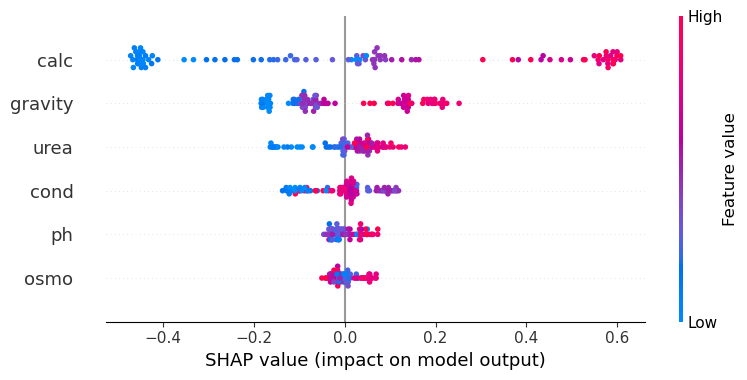

In [23]:
import shap

# Create an explainer object using the best XGBoost model
explainer = shap.Explainer(xgb_classifier_best)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(x_test)

# Plot the SHAP feature importance
shap.summary_plot(shap_values, x_test, feature_names=x_test.columns)


In [21]:
import shap

# Create an explainer object using the best XGBoost model
explainer = shap.Explainer(xgb_classifier_best)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(x_test)

# Compute the absolute sum of SHAP values for each feature
shap_sum = np.abs(shap_values).mean(axis=0)

# Sort the features based on their importance (SHAP sum) in descending order
sorted_indices = np.argsort(shap_sum)[::-1]

# Print the SHAP values and feature names in decreasing order
for idx in sorted_indices:
    print(f"Feature: {x_test.columns[idx]}, SHAP Value: {shap_sum[idx]}")


Feature: calc, SHAP Value: 0.324197918176651
Feature: gravity, SHAP Value: 0.12637770175933838
Feature: urea, SHAP Value: 0.05693468824028969
Feature: cond, SHAP Value: 0.05540759488940239
Feature: ph, SHAP Value: 0.025911863893270493
Feature: osmo, SHAP Value: 0.024321628734469414


After analysing the SHAP values for the features of the best model, we get these final conclusions about the features of the model :-

1. Feature: calc, SHAP Value: 0.324197918176651

The "calc" feature has the highest SHAP value, indicating its strong influence on the model's prediction. A higher value of "calc" suggests a higher concentration of calcium in the urine. It is well-known that calcium oxalate crystals are one of the primary components of kidney stones. Therefore, higher levels of "calc" significantly contribute to predicting the presence of kidney stones. The SHAP value confirms that this feature has the most substantial impact on the model's prediction.

2. Feature: gravity, SHAP Value: 0.12637770175933838

The "gravity" feature has a moderately high SHAP value, indicating its importance in the model's prediction. Specific gravity measures the density of urine relative to water. In the context of kidney stones, a higher specific gravity indicates concentrated urine, which can promote the formation of crystals. Therefore, higher values of "gravity" positively contribute to predicting the presence of kidney stones.

3. Feature: urea, SHAP Value: 0.05693468824028969

The "urea" feature has a relatively lower SHAP value compared to "calc" and "gravity." Urea is a waste product filtered by the kidneys, and its concentration in urine can vary depending on various factors. While the SHAP value suggests that "urea" contributes positively to the model's prediction, its effect might not be as pronounced as "calc" and "gravity." Higher values of "urea" may indicate certain metabolic conditions or dehydration, which can influence the likelihood of kidney stone formation.
